<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://vespa.ai/assets/vespa-ai-logo-heather.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://vespa.ai/assets/vespa-ai-logo-rock.svg">
  <img alt="#Vespa" width="200" src="https://vespa.ai/assets/vespa-ai-logo-rock.svg" style="margin-bottom: 25px;">
</picture>

## Representing ColPali in Vespa

This notebook demonstrates how to represent [ColPali](https://huggingface.co/vidore/colpali) in Vespa. ColPali is a powerful visual language model that can generate embeddings for images and text. In this notebook, we will use ColPali to generate embeddings for images of pdf pages and store them in Vespa. We will also store the base64 encoded image of the pdf page and some meta data like title and url. We will then demonstrate how to retrieve the pdf pages using the embeddings generated by ColPali.

[ColPali: Efficient Document Retrieval with Vision Language Models Manuel Faysse, Hugues Sibille, Tony Wu, Bilel Omrani, Gautier Viaud, Céline Hudelot, Pierre Colombo](https://arxiv.org/abs/2407.01449v2)

ColPail is a combination of [ColBERT](https://blog.vespa.ai/announcing-colbert-embedder-in-vespa/) 
and [PailGemma](https://huggingface.co/blog/paligemma)

>ColPali is enabled by the latest advances in Vision Language Models, notably the PaliGemma model from the Google Zürich team, and leverages multi-vector retrieval through late interaction mechanisms as proposed in ColBERT by Omar Khattab.

Quote from [ColPali: Efficient Document Retrieval with Vision Language Models 👀](https://huggingface.co/blog/manu/colpali)

![ColPali](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/rvRCudun_70rI08NHuU3_.jpeg)

The ColPali model achieves remarkable retrieval performance on the ViDoRe (Visual Document Retrieval Benchmark) dataset. Beating
the previous state-of-the-art by a large margin. 

![ColPali Results](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/J4VzBZpT-YlyGGEmXCHNQ.png)


The TLDR of this notebook:

- Generate an image per PDF page using [pdf2image](https://pypi.org/project/pdf2image/) 
and also extract the text using [pypdf](https://pypdf.readthedocs.io/en/stable/user/extract-text.html). 
- For each page image, use ColPali to obtain the visual multi-vector embeddings

Then we store colbert embeddings in Vespa and use the [long-context variant](https://blog.vespa.ai/announcing-long-context-colbert-in-vespa/)
where we represent the colbert embeddings per document with the tensor `tensor(page{}, token, v[128])`. This enables 
us to use the PDF as document, storing the multiple page embeddings in the same document.
We also store the base64 encoded image, and page meta data like title and url so that we can display it in the result page, but also
use it for RAG with powerful LLMs with vision capabilities. 

At query time, we retrieve using [BM25](https://docs.vespa.ai/en/reference/bm25.html) and use the [ColBERT](https://blog.vespa.ai/announcing-colbert-embedder-in-vespa/) embeddings to rerank the results using the max page score. 


Let us get started. 


Install dependencies: 

In [ ]:
!pip3 install git+https://github.com/ManuelFay/colpali pdf2image pydf

In [2]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoProcessor
from PIL import Image
from io import BytesIO

from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.utils.colpali_processing_utils import process_images, process_queries
from colpali_engine.utils.image_utils import scale_image,get_base64_image

## Load the model

This requires that the HF_TOKEN is set because the underlaying PaliGemma model is hosted on Hugging Face 
and has a [restricive licence](https://ai.google.dev/gemma/terms) that requires authentication.

In [4]:
import os
os.environ["HF_TOKEN"] = "YOUR_HF_TOKEN"

## Load the model

This requires that the HF_TOKEN is set because the model is gated with the gemma license.

In [22]:
if torch.cuda.is_available():
  device = torch.device("cuda")
elif torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cpu")

In [ ]:
model_name = "vidore/colpali"
model = ColPali.from_pretrained("google/paligemma-3b-mix-448", torch_dtype=torch.float32).eval()
model.load_adapter(model_name)
model.to(device)
processor = AutoProcessor.from_pretrained(model_name)

## Working with pdfs

We need to convert a PDF to an array of images. One image per page. We will use pdf2image for this. Secondary
we also extract the text content of the pdf using pypdf.


In [12]:
import requests
from pdf2image import convert_from_path
from pypdf import PdfReader


def download_pdf(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BytesIO(response.content)
    else:
        raise Exception(f"Failed to download PDF: Status code {response.status_code}")

def get_pdf_images(pdf_url):
    # Download the PDF
    pdf_file = download_pdf(pdf_url)
    # Save the PDF temporarily to disk (pdf2image requires a file path)
    with open("temp.pdf", "wb") as f:
        f.write(pdf_file.read())
    reader = PdfReader("temp.pdf")
    page_texts = []
    for page_number in range(len(reader.pages)):
        page = reader.pages[page_number]
        text = page.extract_text()
        page_texts.append(text)
    images = convert_from_path("temp.pdf")
    assert len(images) == len(page_texts)
    return (images, page_texts)

We define a few sample PDFs to work with. 

In [16]:
sample_pdfs = [
        {
            "title": "ColBERTv2: Effective and Efficient Retrieval via Lightweight Late Interaction",
            "url": "https://arxiv.org/pdf/2112.01488.pdf",
            "authors": "Keshav Santhanam, Omar Khattab, Jon Saad-Falcon, Christopher Potts, Matei Zaharia",
        },
        {
            "title": "ColBERT: Efficient and Effective Passage Search via Contextualized Late Interaction over BERT",
            "url": "https://arxiv.org/pdf/2004.12832.pdf",
            "authors": "Omar Khattab, Matei Zaharia",
        }
]

Now we can convert the PDFs to images and extract the text content.  

In [19]:
for pdf in sample_pdfs:
  page_images, page_texts = get_pdf_images(pdf['url'])
  pdf['images'] = page_images
  pdf['texts'] = page_texts


Just view the first image of the first PDF to see if it worked. This is the input to ColPali.

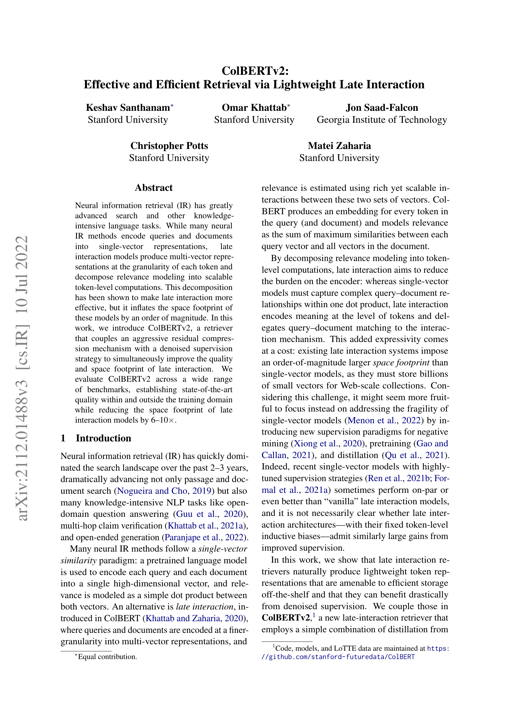

In [20]:
from IPython.display import display
display(scale_image(sample_pdfs[0]['images'][0],720))

Now use ColPali to generate embeddings for the images.

In [21]:

for pdf in sample_pdfs:
  page_embeddings = []
  dataloader = DataLoader(
        pdf['images'],
        batch_size=2,
        shuffle=False,
        collate_fn=lambda x: process_images(processor, x),
    )
  for batch_doc in tqdm(dataloader):
    with torch.no_grad():
      batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
      embeddings_doc = model(**batch_doc)
      page_embeddings.extend(list(torch.unbind(embeddings_doc.to("cpu"))))
  pdf['embeddings'] = page_embeddings

100%|██████████| 5/5 [00:43<00:00,  8.75s/it]


Now we are done with the document side embeddings, we now want to produce Vespa json feed data. The following code will produce a json feed file that can be used to feed to Vespa. We use binarization of the vector embeddings to reduce their size. Read
more about binarization in the [colbert blog post](https://blog.vespa.ai/announcing-colbert-embedder-in-vespa/).

In [37]:
import numpy as np
from typing import Dict, List
from binascii import hexlify

def binarize_token_vectors_hex(vectors: List[torch.Tensor]) -> Dict[str, str]:
    vespa_tensor = list()
    for page_id in range(0, len(vectors)):
        page_vector = vectors[page_id]
        binarized_token_vectors = np.packbits(
            np.where(page_vector > 0, 1, 0), axis=1).astype(np.int8)
        for token_index in range(0, len(page_vector)):
            values = str(hexlify(binarized_token_vectors[token_index].tobytes()), "utf-8")
            if (
                values == "00000000000000000000000000000000"
            ):  # skip empty vectors due to padding of batch
                continue
            vespa_tensor_cell = {
                "address": {"page": page_id, "token": token_index},
                "values": values,
            }
            vespa_tensor.append(vespa_tensor_cell)

    return vespa_tensor

In [60]:
vespa_feed = []
for idx,pdf in enumerate(sample_pdfs):
  images_base_64 = []
  for image in pdf['images']:
    images_base_64.append(get_base64_image(image,add_url_prefix=False))
  pdf['images_base_64'] = images_base_64
  doc = {
      "fields": {
          "url": pdf['url'],
          "title": pdf['title'],
          "images": pdf['images_base_64'],
          "texts": pdf['texts'], # Array of text per page
          "colbert": { # Colbert embeddings per page
              "blocks": binarize_token_vectors_hex(pdf['embeddings'])
          }
      }
  }
  vespa_feed.append(doc)

## Configure Vespa
[PyVespa](https://pyvespa.readthedocs.io/en/latest/) helps us build the [Vespa application package](https://docs.vespa.ai/en/application-packages.html).
A Vespa application package consists of configuration files, schemas, models, and code (plugins).

First, we define a [Vespa schema](https://docs.vespa.ai/en/schemas.html) with the fields we want to store and their type.

In [ ]:
!pip3.11 install pyvespa

In [115]:
from vespa.package import Schema, Document, Field, FieldSet

colbert_schema = Schema(
    name="doc",
    document=Document(
        fields=[
            Field(name="url", type="string", indexing=["summary"]),
            Field(
                name="title",
                type="string",
                indexing=["summary", "index"],
                index="enable-bm25",
            ),
            Field(
                name="texts",
                type="array<string>",
                indexing=["index"],
                index="enable-bm25",
            ),
            Field(
                name="images",
                type="array<string>",
                indexing=["summary"],
            ),
            Field(
                name="colbert",
                type="tensor<int8>(page{}, token{}, v[16])",
                indexing=["attribute"],
            )
        ]
    ),
    fieldsets=[FieldSet(name="default", fields=["title", "texts"])]
)

In [116]:
from vespa.package import ApplicationPackage

vespa_app_name = "visionrag"
vespa_application_package = ApplicationPackage(
    name=vespa_app_name, schema=[colbert_schema]
)

Now we define how we want to rank the pages. We use BM25 for the text and ColBERT for the image embeddings. This means
that we retrieve efficiently to find relevant PDF documents, then we use the ColPALI embeddings to rerank the pages within the document
and where the document level score is the max of the page scores. We also return all the page level scores so that we can
render multiple pages in the search result. As LLMs gets longer context windows, we can also input more than a single page. 

In [117]:
from vespa.package import RankProfile, Function, FirstPhaseRanking, SecondPhaseRanking

colbert_profile = RankProfile(
    name="default",
    inputs=[("query(qt)", "tensor<float>(querytoken{}, v[128])")],
    functions=[
        Function(
            name="max_sim_per_page",
            expression="""
                sum(
                    reduce(
                        sum(
                            query(qt) * unpack_bits(attribute(colbert)) , v
                        ),
                        max, token
                    ),
                    querytoken
                )
            """,
        ),
        Function(
            name="max_sim", expression="reduce(max_sim_per_page, max, page)"
        ),
        Function(
            name="bm25_score", expression="bm25(title) + bm25(texts)"
        )
    ],
    first_phase=FirstPhaseRanking(expression="bm25_score"),
    second_phase=SecondPhaseRanking(expression="max_sim", rerank_count=10),
    match_features=["max_sim_per_page", "bm25_score"],
)
colbert_schema.add_rank_profile(colbert_profile)

## Deploy the application to Vespa Cloud

With the configured application, we can deploy it to [Vespa Cloud](https://cloud.vespa.ai/en/).
It is also possible to deploy the app using docker; see the [Hybrid Search - Quickstart](https://pyvespa.readthedocs.io/en/latest/getting-started-pyvespa.html) guide for
an example of deploying it to a local docker container.


In [ ]:
!pip3 install vespacli

To deploy the application to Vespa Cloud we need to create a tenant in the Vespa Cloud:

Create a tenant at [console.vespa-cloud.com](https://console.vespa-cloud.com/) (unless you already have one).
This step requires a Google or GitHub account, and will start your [free trial](https://cloud.vespa.ai/en/free-trial).
Make note of the tenant name, it is used in the next steps.


In [ ]:
import os

os.environ["TENANT_NAME"] = "samples"  # Replace with your tenant name

vespa_cli_command = (
    f'vespa config set application {os.environ["TENANT_NAME"]}.{vespa_app_name}'
)

!vespa config set target cloud
!{vespa_cli_command}
!vespa auth cert -N

Validate that certificates are ok and deploy the application to Vespa Cloud.

In [56]:
from os.path import exists
from pathlib import Path

cert_path = (
    Path.home()
    / ".vespa"
    / f"{os.environ['TENANT_NAME']}.{vespa_app_name}.default/data-plane-public-cert.pem"
)
key_path = (
    Path.home()
    / ".vespa"
    / f"{os.environ['TENANT_NAME']}.{vespa_app_name}.default/data-plane-private-key.pem"
)

if not exists(cert_path) or not exists(key_path):
    print(
        "ERROR: set the correct paths to security credentials. Correct paths above and rerun until you do not see this error"
    )

Note that the subsequent Vespa Cloud deploy call below will add `data-plane-public-cert.pem` to the application before deploying it to Vespa Cloud, so that
you have access to both the private key and the public certificate. At the same time, Vespa Cloud only knows the public certificate.

### Configure Vespa Cloud control-plane security

Authenticate to generate a tenant level control plane API key for deploying the applications to Vespa Cloud, and save the path to it.

The generated tenant api key must be added in the Vespa Console before attemting to deploy the application.

```
To use this key in Vespa Cloud click 'Add custom key' at
https://console.vespa-cloud.com/tenant/TENANT_NAME/account/keys
and paste the entire public key including the BEGIN and END lines.
```


In [ ]:
!vespa auth api-key

from pathlib import Path

api_key_path = Path.home() / ".vespa" / f"{os.environ['TENANT_NAME']}.api-key.pem"

### Deploy to Vespa Cloud

Now that we have data-plane and control-plane credentials ready, we can deploy our application to Vespa Cloud!

`PyVespa` supports deploying apps to the [development zone](https://cloud.vespa.ai/en/reference/environments#dev-and-perf).

> Note: Deployments to dev and perf expire after 7 days of inactivity, i.e., 7 days after running deploy. This applies to all plans, not only the Free Trial. Use the Vespa Console to extend the expiry period, or redeploy the application to add 7 more days.


In [118]:
from vespa.deployment import VespaCloud


def read_secret():
    """Read the API key from the environment variable. This is
    only used for CI/CD purposes."""
    t = os.getenv("VESPA_TEAM_API_KEY")
    if t:
        return t.replace(r"\n", "\n")
    else:
        return t


vespa_cloud = VespaCloud(
    tenant=os.environ["TENANT_NAME"],
    application=vespa_app_name,
    key_content=read_secret() if read_secret() else None,
    key_location=api_key_path,
    application_package=vespa_application_package,
)

Now deploy the app to Vespa Cloud dev zone.

The first deployment typically takes 2 minutes until the endpoint is up.


In [ ]:
from vespa.application import Vespa

app: Vespa = vespa_cloud.deploy()

Now we can feed our data to the Vespa application using the `feed_data_point` method. This example
uses the synchronous feed method, but it is also possible to use the asynchronous. 

In [61]:
from vespa.io import VespaResponse

with app.syncio() as sync:
    for operation in vespa_feed:
        fields = operation["fields"]
        response: VespaResponse = sync.feed_data_point(
            data_id=fields["url"], fields=fields, schema="doc"
        )
        if not response.is_successful():
            print(response.json())
    

## Querying Vespa

Ok, so now we have indexed the PDF pages in Vespa. Let us now obtain ColPali embeddings for a text query and 
use it to match against the indexed PDF pages.


The ColPali model text encoder needs a "dummy" image. 

In [62]:
dummy_image = Image.new("RGB", (448, 448), (255, 255, 255))

Our demo query: 

> Composition of the Lotte Benchmark

In [111]:
queries = ["Composition of the LoTTE benchmark"]

Obtain the query embeddings using ColPali.

In [112]:
dataloader = DataLoader(
        queries,
        batch_size=1,
        shuffle=False,
        collate_fn=lambda x: process_queries(processor, x, dummy_image),
    )
qs = []
for batch_query in dataloader:
  with torch.no_grad():
    batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
    embeddings_query = model(**batch_query)
    qs.extend(list(torch.unbind(embeddings_query.to("cpu"))))


A simple routine to format the ColPali multi-vector emebeddings to a format that can be used in Vespa.
See [querying with tensors](https://docs.vespa.ai/en/tensor-user-guide.html#querying-with-tensors) for more details. 

In [113]:
def float_query_token_vectors(vectors: torch.Tensor) -> Dict[str, List[float]]:
    vespa_token_dict = dict()
    for index in range(0, len(vectors)):
        vespa_token_dict[index] = vectors[index].tolist()
    return vespa_token_dict

A simple routine to display the results. Notice that each hit is a PDF document. Within a PDF document
we have multiple pages and we have the ColBERT MaxSim score for each page. 

The PDF documents are ranked by the maxium page score. But, we have access to all the page level scores and 
below we display the top 2 pages for each PDF document. We convert the base64 encoded image to a PIL image 
for rendering. We could also render the extracted text, but we skip that for now.

In [125]:
from IPython.display import display, HTML
import base64

def display_query_results(query, response):
    """
    Displays the query result, including the two best matching pages per matched pdf.
    """
    html_content = f'<h2>Query text: {query}</h2>'
    
    for i, hit in enumerate(response.hits[:2]):  # Adjust to show more hits if needed
        title = hit['fields']['title']
        url = hit['fields']['url']
        match_scores = hit['fields']["matchfeatures"]['max_sim_per_page']
        images = hit['fields']['images']
        
        html_content += f'<h3>Result {i + 1}</h3>'
        html_content += f'<p><strong>Title:</strong> <a href="{url}">{title}</a></p>'

        # Find the two best matching pages
        sorted_pages = sorted(match_scores.items(), key=lambda x: x[1], reverse=True)
        best_pages = sorted_pages[:2]

        for j, (page, score) in enumerate(best_pages):
            page = int(page)
            image_data = base64.b64decode(images[page])
            image = Image.open(BytesIO(image_data))
            scaled_image = scale_image(image, 648)

            buffered = BytesIO()
            scaled_image.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            html_content += f'<p><strong>Best Matching Page {page+1} for PDF document:</strong> with MaxSim score {score:.2f}</p>'
            html_content += f'<img src="data:image/png;base64,{img_str}" style="max-width:100%;">'

    display(HTML(html_content))

Query Vespa with a text query and display the results.


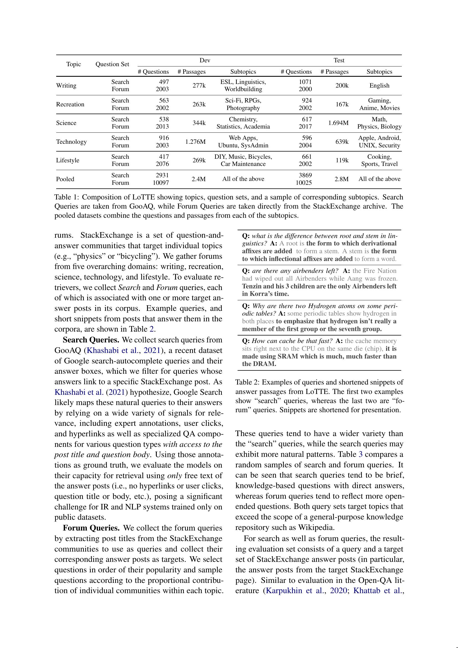
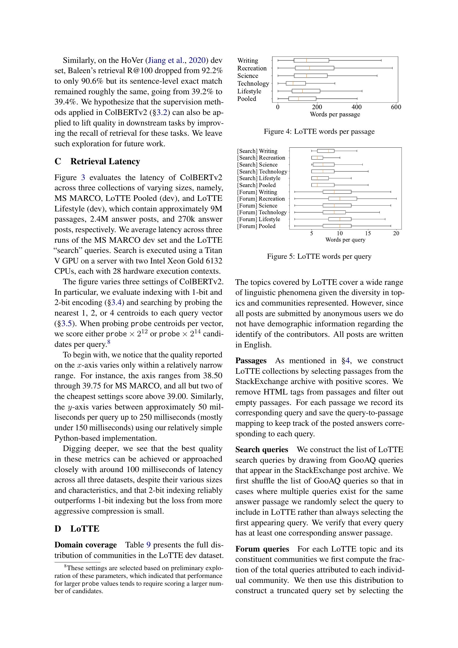
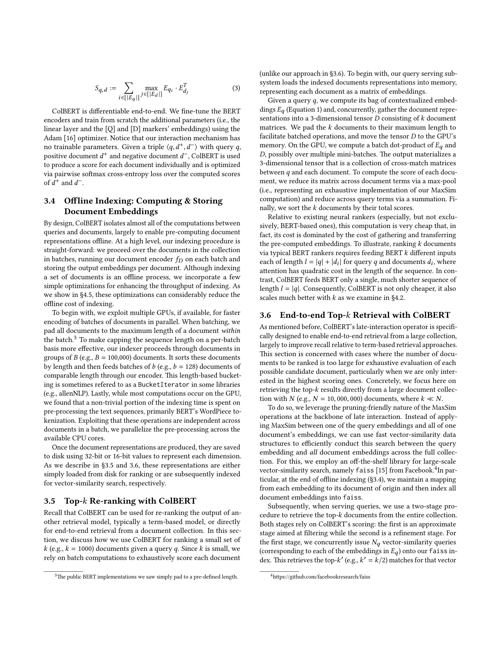
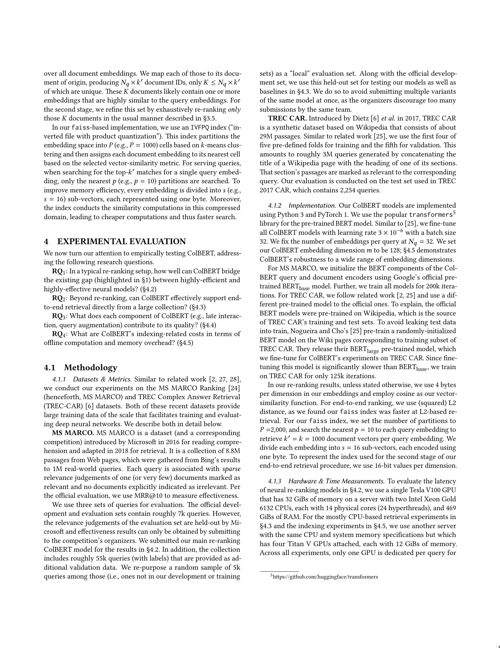

In [126]:
from vespa.io import VespaQueryResponse

for idx,query in enumerate(queries):
    response: VespaQueryResponse = app.query(
        yql="select title,url,images from doc where userInput(@userQuery)",
        ranking="default",
        userQuery=query,
        body={
            "presentation.format.tensors": "short-value",
            "input.query(qt)": float_query_token_vectors(qs[idx])
        },
    )
    assert response.is_successful()
    display_query_results(query, response)



## RAG with LLMs with strong vision capabilities. 

Now we can use the top k documents to answer the question using a LLM with vision capabilties. We will use the
Gemini Flash model for this. We simply input the best matching PDF page image and ask the question.


In [141]:
import google.generativeai as genai
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

Just extract the best page image from the first hit to demonstrate how to use the image with Gemini Flash to answer the question.

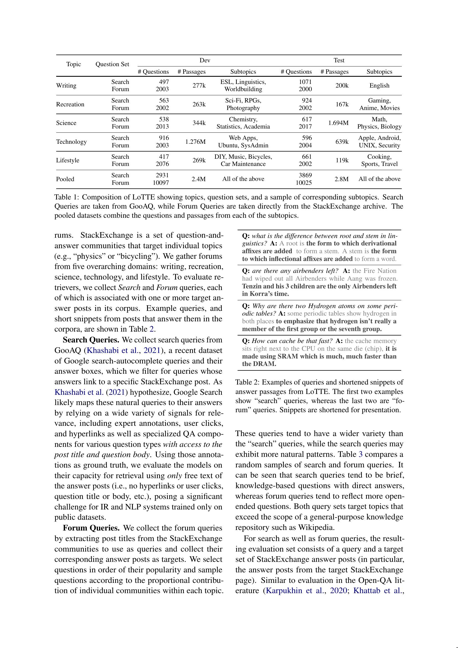

In [142]:
best_hit = response.hits[0]
pdf_url = best_hit['fields']['url']
pdf_title = best_hit['fields']['title']
match_scores = best_hit['fields']["matchfeatures"]['max_sim_per_page']
images = best_hit['fields']['images']
sorted_pages = sorted(match_scores.items(), key=lambda x: x[1], reverse=True)
best_page,score = sorted_pages[0]
best_page = int(best_page)
image_data = base64.b64decode(images[best_page])
image = Image.open(BytesIO(image_data))
scaled_image = scale_image(image, 648)
display(scaled_image)

In [ ]:
model = genai.GenerativeModel(model_name="gemini-1.5-flash")
response = model.generate_content([queries[0], image])

In [162]:
from IPython.display import Markdown, display
markdown_text = response.candidates[0].content.parts[0].text
display(Markdown(markdown_text))

The LoTTE benchmark is composed of five topics: writing, recreation, science, technology, and lifestyle. Each topic includes both "Search" and "Forum" question sets.  

The "Search" questions are taken from the GooAQ dataset, which contains Google Search autocomplete queries. The "Forum" questions are taken directly from the StackExchange archive. These questions are further divided into subtopics.

Here is a breakdown of the topics, question sets, and subtopics:

**Writing:**
* **Search:** 497 questions
    * Subtopics: ESL, Linguistics, Worldbuilding
* **Forum:** 2003 questions
    * Subtopics: English

**Recreation:**
* **Search:** 563 questions
    * Subtopics: Sci-Fi, RPGs, Photography
* **Forum:** 2002 questions
    * Subtopics: Gaming, Anime, Movies

**Science:**
* **Search:** 538 questions
    * Subtopics: Chemistry, Statistics, Academia
* **Forum:** 2017 questions
    * Subtopics: Math, Physics, Biology

**Technology:**
* **Search:** 916 questions
    * Subtopics: Web Apps, Ubuntu, SysAdmin
* **Forum:** 2017 questions
    * Subtopics: Apple, Android, UNIX, Security

**Lifestyle:**
* **Search:** 417 questions
    * Subtopics: DIY, Music, Bicycles, Car Maintenance
* **Forum:** 2076 questions
    * Subtopics: Cooking, Sports, Travel

The benchmark also includes a "Pooled" set, which combines all the topics and their respective question sets.

* **Search:** 2931 questions
    * Subtopics: All of the above
* **Forum:** 10097 questions
    * Subtopics: All of the above 

The LoTTE benchmark is designed to evaluate the capacity of retrieval systems on both search and forum queries, providing a comprehensive benchmark for research in information retrieval.


## Summary 

In this notebook, we have demonstrated how to represent ColPali in Vespa. We have used ColPali to generate embeddings for images of pdf pages and stored them in Vespa. We have also stored the base64 encoded image of the pdf page and some meta data like title and url. We have then demonstrated how to retrieve the pdf pages using the embeddings generated by ColPali. We have also demonstrated how to use the top k documents to answer a question using a LLM with vision capabilities. 
